The used dataset can be found at [Flowers Recognition](https://www.kaggle.com/datasets/alxmamaev/flowers-recognition?datasetId=8782&sortBy=voteCount)

## 2.The modeling objective clearly

### What type of data is it? & What type of problem is it?

The dataset contains images of 5 types flower. 
  * Daisy
  * Dandelion
  * Rose
  * Sunflower
  * Tulip
  
  The idea is to recognize the flower from given picture of the flower. Hence it's a classification problem.

### Planing

* Try CNN 
* Try ResNet
* Try GoogleNet (Transfer learning)

Find best model in all and save it

## 3. Data Cleaning

In [ ]:
# Imports
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import opendatasets as od
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, ConcatDataset
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
import jovian
import matplotlib.image as mpimg

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

### Downloading Dataset from Kaggle

In [ ]:
# Dowload the dataset
dataset_url = "https://www.kaggle.com/datasets/alxmamaev/flowers-recognition?datasetId=8782&sortBy=voteCount"
# Look into the data directory
data_dir = './flowers-recognition/flowers'

if not os.path.isdir(data_dir):
    od.download(dataset_url)

classes = os.listdir(data_dir)
print(classes)


['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


Take a quick look at data

Lets check total number of files in each classes

In [ ]:
for class_name in classes:
   total_images =  len(os.listdir(os.path.join(data_dir, class_name)))
   print(f'{class_name.capitalize()}: contains {total_images} images')

Daisy: contains 764 images
Dandelion: contains 1052 images
Rose: contains 784 images
Sunflower: contains 733 images
Tulip: contains 984 images


There is not a huge difference in size of each classes data/images count

In [ ]:
daisy_dir = os.listdir(os.path.join(data_dir, 'daisy'))
daisy_dir[:5]

['100080576_f52e8ee070_n.jpg',
 '10140303196_b88d3d6cec.jpg',
 '10172379554_b296050f82_n.jpg',
 '10172567486_2748826a8b.jpg',
 '10172636503_21bededa75_n.jpg']

In [ ]:
rose_dir = os.listdir(os.path.join(data_dir, 'rose'))
rose_dir[:5]

['10090824183_d02c613f10_m.jpg',
 '102501987_3cdb8e5394_n.jpg',
 '10503217854_e66a804309.jpg',
 '10894627425_ec76bbc757_n.jpg',
 '110472418_87b6a3aa98_m.jpg']

In [ ]:
def show_example(img, label):
    img = mpimg.imread(img)
    print(f'Label: {label} with shape. {img.shape}')
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.set_xticks([]); ax.set_yticks([])
    plt.imshow(img)

Label: rose with shape. (240, 179, 3)


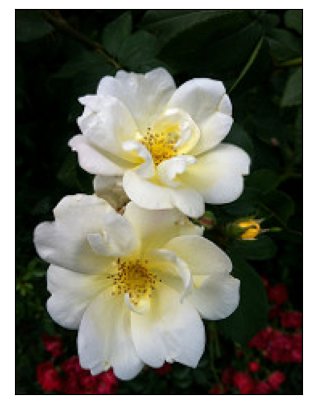

In [ ]:
img_name = rose_dir[0]
img_path = os.path.join(os.path.join(data_dir, 'rose'), img_name) 
show_example(img_path, 'rose')

Label: daisy with shape. (263, 320, 3)


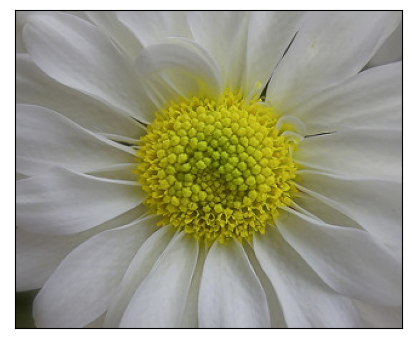

In [ ]:
img_name = daisy_dir[0]
img_path = os.path.join(os.path.join(data_dir, 'daisy'), img_name) 
show_example(img_path, 'daisy')

It can be noticed that the images are not normalized. 

### Data transforms (normalization & data augmentation)

#### Calculate the Mean and Standard Deviation for Normalizing the dataset

In [ ]:
IMAGE_RESIZE = (150, 150)

In [ ]:
def calculate_mean_std(dataset_path):
    """
    Calculate Mean and Stanndard deviation of all the dataset images
    
    Reference 
    1. https://towardsdatascience.com/how-to-calculate-the-mean-and-standard-deviation-normalizing-datasets-in-pytorch-704bd7d05f4c
    2. https://www.youtube.com/watch?v=y6IEcEBRZks
    """
    # 0 = Num of examples in batch
    # 1 = Channels (we do not need it)
    # 2 = height
    # 3 = wight
    dim = [0, 2, 3]
    
    # Prepare data for calculation
    x_form = tt.Compose([tt.Resize(IMAGE_RESIZE), 
                        tt.ToTensor()
                        ])
    dataset = ImageFolder(data_dir, transform=x_form)
    dataset_loader = DataLoader(dataset=dataset, batch_size=512, shuffle=True, num_workers=8)

    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in dataset_loader: 
    # Mean over batch, height and width, but not over the channels
        channels_sum += torch.mean(data, dim=dim)
        channels_squared_sum += torch.mean(data**2, dim=dim)
        num_batches += 1

    mean = channels_sum/num_batches

    # std = sqrt(E[X**2] - (E[X])**2)
    # Where E[X^2] - mean of the squared data
    #       E[X]^2 - square of the mean of data
    std = np.sqrt(channels_squared_sum/num_batches - np.square(mean))

    return mean, std

In [ ]:
mean_std = calculate_mean_std(data_dir)
mean = tuple(scaler.item() for scaler in mean_std[0])
std = tuple(scaler.item() for scaler in mean_std[1])
stats = (mean, std)
stats

((0.45794159173965454, 0.41903141140937805, 0.2990935444831848),
 (0.2916566729545593, 0.26067906618118286, 0.28365588188171387))

### Data transforms (normalization & data augmentation)

Creating multiple datasets from original dataset to increase total size of training set

In [ ]:
transformer = {
    'original' : tt.Compose([
        tt.Resize(IMAGE_RESIZE), 
        tt.ToTensor(),
        tt.Normalize(*stats,inplace=True)
    ]),
    'dataset1' : tt.Compose([
        tt.Resize(IMAGE_RESIZE),
        tt.RandomAffine(degrees=11, translate=(0.1,0.1), scale=(0.8,0.8)),
        tt.RandomHorizontalFlip(),
        tt.ToTensor(), 
        tt.Normalize(*stats,inplace=True)
    ]),
    'dataset2' : tt.Compose([
        tt.Resize(IMAGE_RESIZE),
        tt.RandomRotation(5),
        tt.RandomHorizontalFlip(p=0.2),
        tt.ToTensor(),
        tt.Normalize(*stats,inplace=True)
    ]),    
    'dataset3' : tt.Compose([
        tt.Resize(IMAGE_RESIZE),
        tt.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        tt.RandomRotation(20),
        tt.RandomHorizontalFlip(p=0.5),
        tt.ToTensor(),
        tt.Normalize(*stats,inplace=True)
    ]),
}

Separate validation data from training data

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
original_dataset = ImageFolder(data_dir, transform=transformer['original'])
train_val_dataset, test_ds = train_test_split(original_dataset, test_size=0.2, shuffle=True, random_state=42) 
train_dataset, val_ds = train_test_split(train_val_dataset, test_size=0.1, shuffle=True, random_state=42) 

In [ ]:
val_ds

[(tensor([[[-0.9516, -1.0054, -1.0458,  ..., -0.6962, -0.7634, -0.8037],
           [-1.0861, -1.1264, -1.0995,  ..., -0.6020, -0.6155, -0.6693],
           [-1.1533, -1.1264, -1.0592,  ..., -0.5483, -0.5617, -0.6020],
           ...,
           [-1.3281, -1.3953, -1.4222,  ..., -0.6693, -0.6289, -0.9785],
           [-1.3953, -1.4222, -1.4357,  ..., -0.8710, -0.7231, -0.9113],
           [-1.4222, -1.4088, -1.4222,  ..., -1.0726, -0.9785, -0.9785]],
  
          [[-0.4341, -0.5243, -0.6296,  ..., -0.2836, -0.3287, -0.3137],
           [-0.6748, -0.7650, -0.7650,  ..., -0.2234, -0.2234, -0.2385],
           [-0.8553, -0.8402, -0.7801,  ..., -0.2535, -0.2234, -0.2084],
           ...,
           [-1.2615, -1.3517, -1.3668,  ..., -0.2836, -0.2535, -0.6296],
           [-1.3367, -1.3818, -1.3818,  ..., -0.5093, -0.3438, -0.5243],
           [-1.3517, -1.3517, -1.3517,  ..., -0.7349, -0.6296, -0.6296]],
  
          [[-0.1420, -0.2526, -0.3355,  ..., -0.9576, -0.9991, -0.9991],
           

In [ ]:
# create train and val dataset from remaining and  augmented dataset
train_ds = ConcatDataset([train_dataset, 
                        ImageFolder(data_dir, transform=transformer['dataset1']),
                        ImageFolder(data_dir, transform=transformer['dataset2']),
                        ImageFolder(data_dir, transform=transformer['dataset3']),
                        ])


In [ ]:
BATCH_SIZE=64

In [ ]:
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE*2, num_workers=2, pin_memory=True)

In [ ]:
# Visualized normalized training dataset
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


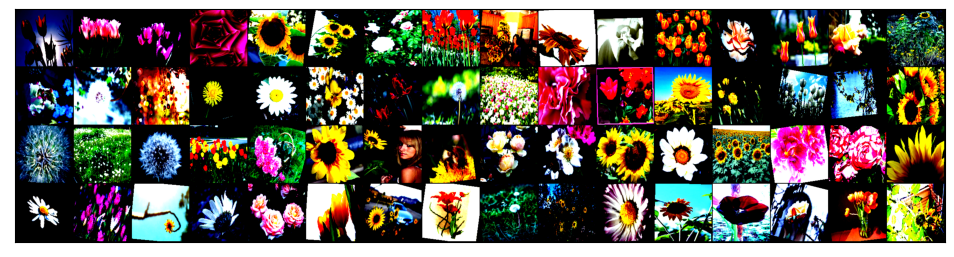

In [ ]:
show_batch(train_dl)

### Using GPU

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

Loading data onto GPU

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

## 4. Modeling 

### A. Define a model (network architecture)
### B. Pick some hyperparameters
### C. Train the model

Base class for Images classification

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [ ]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [ ]:
def fit_one_cycle(epochs:int, 
                  max_lr:float, 
                  model:object, 
                  train_loader:DataLoader, 
                  val_loader:DataLoader, 
                  weight_decay:float=0, 
                  grad_clip:bool=None, 
                  opt_func=torch.optim.SGD) -> list[dict]:

    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), 
                         max_lr,
                         weight_decay=weight_decay)

    # Set up one-cycle learning rate scheduler
    lmbda = lambda epoch: 0.65 ** epoch
    # sched = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lmbda)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

#### Trying with CNN

In [ ]:
class FlowersCNNModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.linear_input = 784
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(),
             
            nn.Linear(256*18*18, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
        
    def forward(self, xb):
        return self.network(xb)

In [ ]:
num_classes = len(classes) # 5

In [ ]:
flower_cnn = to_device(FlowersCNNModel(), device=device)

In [ ]:
history = [evaluate(flower_cnn, val_dl)]
history

[{'val_loss': 2.307180166244507, 'val_acc': 0.0}]

##### Trying with Adam optimizer

In [ ]:
epochs = 8
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
history += fit_one_cycle(epochs, max_lr, flower_cnn, train_dl, val_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00394, train_loss: 1.3340, val_loss: 1.2575, val_acc: 0.5420
Epoch [1], last_lr: 0.00935, train_loss: 1.2522, val_loss: 1.6152, val_acc: 0.2188
Epoch [2], last_lr: 0.00972, train_loss: 26.6471, val_loss: 1611.2546, val_acc: 0.2188
Epoch [3], last_lr: 0.00812, train_loss: 3333.2410, val_loss: 1.6189, val_acc: 0.2589
Epoch [4], last_lr: 0.00556, train_loss: 1.6157, val_loss: 1.6080, val_acc: 0.2589
Epoch [5], last_lr: 0.00283, train_loss: 1.6102, val_loss: 1.6060, val_acc: 0.2589
Epoch [6], last_lr: 0.00077, train_loss: 1.6083, val_loss: 1.6045, val_acc: 0.2589
Epoch [7], last_lr: 0.00000, train_loss: 1.6076, val_loss: 1.6043, val_acc: 0.2589


##### Trying with SGD optimizer

In [ ]:
flower_cnn = to_device(FlowersCNNModel(), device=device)
epochs = 25
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4

In [ ]:
history += fit_one_cycle(epochs, max_lr, flower_cnn, train_dl, val_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay)

Epoch [0], last_lr: 0.00081, train_loss: 2.0142, val_loss: 1.5947, val_acc: 0.2949
Epoch [1], last_lr: 0.00198, train_loss: 1.5287, val_loss: 1.5408, val_acc: 0.3046
Epoch [2], last_lr: 0.00371, train_loss: 1.4394, val_loss: 1.3917, val_acc: 0.4019
Epoch [3], last_lr: 0.00570, train_loss: 1.2302, val_loss: 1.0870, val_acc: 0.5431
Epoch [4], last_lr: 0.00760, train_loss: 1.0308, val_loss: 0.9464, val_acc: 0.6122
Epoch [5], last_lr: 0.00908, train_loss: 0.9333, val_loss: 0.8976, val_acc: 0.6017
Epoch [6], last_lr: 0.00989, train_loss: 0.8430, val_loss: 0.8130, val_acc: 0.6760
Epoch [7], last_lr: 0.00998, train_loss: 0.7517, val_loss: 0.6476, val_acc: 0.7686
Epoch [8], last_lr: 0.00982, train_loss: 0.6744, val_loss: 0.5694, val_acc: 0.7838
Epoch [9], last_lr: 0.00950, train_loss: 0.5848, val_loss: 0.4361, val_acc: 0.8611
Epoch [10], last_lr: 0.00905, train_loss: 0.5124, val_loss: 0.3336, val_acc: 0.8785
Epoch [11], last_lr: 0.00846, train_loss: 0.4488, val_loss: 0.2895, val_acc: 0.9079
Ep

In [ ]:
# Plot accuracies
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

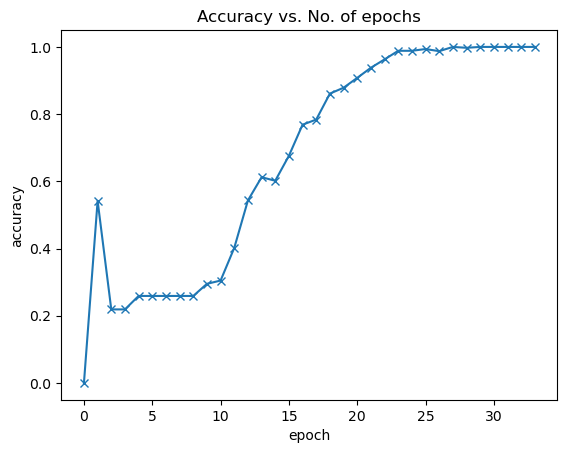

In [ ]:
plot_accuracies(history)

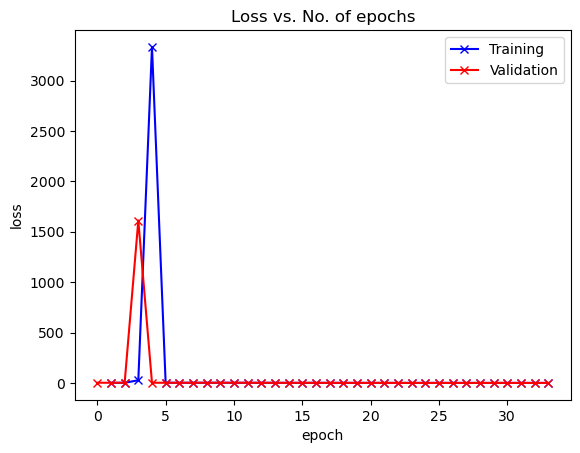

In [ ]:
plot_losses(history)

#### Trying with ResNet9

![resnet-9](https://github.com/lambdal/cifar10-fast/raw/master/net.svg?sanitize=true)

In [ ]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512*4*4, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [ ]:
res_net_model = to_device(ResNet9(3, num_classes), device)
epochs = 20
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4

In [ ]:
torch.cuda.empty_cache()

In [ ]:
res_net_history = [evaluate(res_net_model, val_dl)]
res_net_history

[{'val_loss': 1.6136454343795776, 'val_acc': 0.14710648357868195}]

In [ ]:
res_net_history += fit_one_cycle(epochs, max_lr, res_net_model, train_dl, val_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay)

Epoch [0], last_lr: 0.00104, train_loss: 1.3789, val_loss: 1.2577, val_acc: 0.6430
Epoch [1], last_lr: 0.00279, train_loss: 1.5303, val_loss: 1.5817, val_acc: 0.5925
Epoch [2], last_lr: 0.00519, train_loss: 1.7249, val_loss: 1.7335, val_acc: 0.5705
Epoch [3], last_lr: 0.00760, train_loss: 1.0847, val_loss: 0.9413, val_acc: 0.6843
Epoch [4], last_lr: 0.00936, train_loss: 0.8164, val_loss: 0.9631, val_acc: 0.7088
Epoch [5], last_lr: 0.01000, train_loss: 0.6304, val_loss: 0.6265, val_acc: 0.7448
Epoch [6], last_lr: 0.00987, train_loss: 0.5107, val_loss: 0.5242, val_acc: 0.8452
Epoch [7], last_lr: 0.00950, train_loss: 0.4420, val_loss: 0.3368, val_acc: 0.8905
Epoch [8], last_lr: 0.00891, train_loss: 0.3782, val_loss: 0.2926, val_acc: 0.8975
Epoch [9], last_lr: 0.00812, train_loss: 0.2971, val_loss: 0.1965, val_acc: 0.9298
Epoch [10], last_lr: 0.00717, train_loss: 0.2832, val_loss: 0.1680, val_acc: 0.9491
Epoch [11], last_lr: 0.00611, train_loss: 0.2249, val_loss: 0.1135, val_acc: 0.9707
Ep

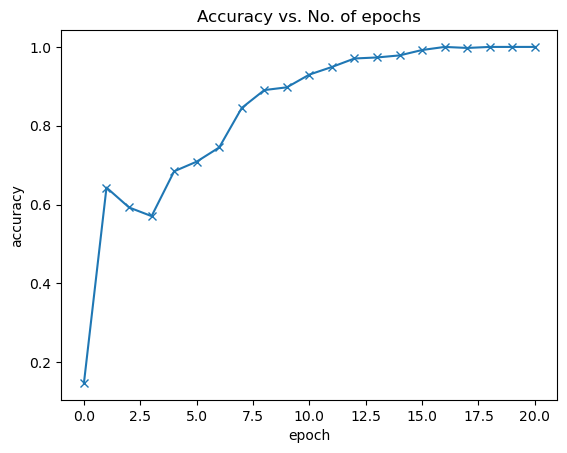

In [ ]:
plot_accuracies(res_net_history)

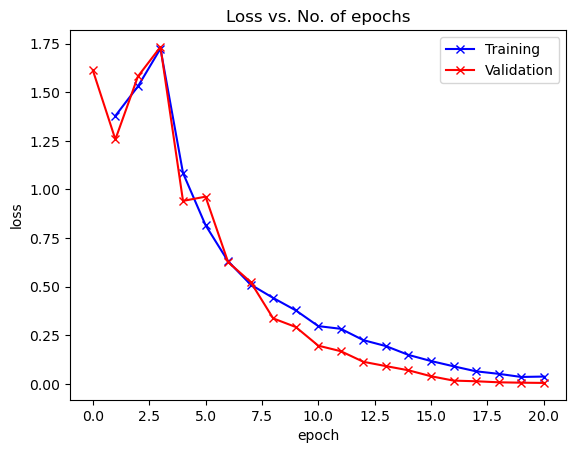

In [ ]:
plot_losses(res_net_history)

#### trying with transferlearning using GoogleNet

In [ ]:
import torchvision.models as models

In [ ]:
class XferLearningGooglenet(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        # Use a pretrained model
        self.network = models.googlenet(weights='DEFAULT')
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, num_classes)
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))
    
    def freeze(self):
        # To freeze the residual layers
        for param in self.network.parameters():
            param.require_grad = False
        for param in self.network.fc.parameters():
            param.require_grad = True
    
    def unfreeze(self):
        # Unfreeze all layers
        for param in self.network.parameters():
            param.require_grad = True

In [ ]:
xfer_learning_model = to_device(XferLearningGooglenet(3, num_classes), device)
epochs = 10
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4

In [ ]:
xfer_lr_history = [evaluate(xfer_learning_model, val_dl)]
xfer_lr_history

[{'val_loss': 1.6183671951293945, 'val_acc': 0.1771412044763565}]

First, freeze the googlenet layers and train some epochs. This only trains the final layer to start classifying the images.

In [ ]:
xfer_learning_model.freeze()

In [ ]:
xfer_lr_history += fit_one_cycle(epochs, max_lr, xfer_learning_model, train_dl, val_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay)

Epoch [0], last_lr: 0.00279, train_loss: 1.4489, val_loss: 1.1815, val_acc: 0.8255
Epoch [1], last_lr: 0.00759, train_loss: 1.0969, val_loss: 1.0048, val_acc: 0.9187
Epoch [2], last_lr: 0.01000, train_loss: 1.0062, val_loss: 0.9623, val_acc: 0.9506
Epoch [3], last_lr: 0.00950, train_loss: 0.9729, val_loss: 0.9448, val_acc: 0.9648
Epoch [4], last_lr: 0.00812, train_loss: 0.9537, val_loss: 0.9316, val_acc: 0.9748
Epoch [5], last_lr: 0.00611, train_loss: 0.9425, val_loss: 0.9232, val_acc: 0.9863
Epoch [6], last_lr: 0.00389, train_loss: 0.9357, val_loss: 0.9221, val_acc: 0.9889
Epoch [7], last_lr: 0.00188, train_loss: 0.9298, val_loss: 0.9203, val_acc: 0.9889
Epoch [8], last_lr: 0.00050, train_loss: 0.9268, val_loss: 0.9201, val_acc: 0.9889
Epoch [9], last_lr: 0.00000, train_loss: 0.9275, val_loss: 0.9193, val_acc: 0.9889


In [ ]:
train_time='3:44'

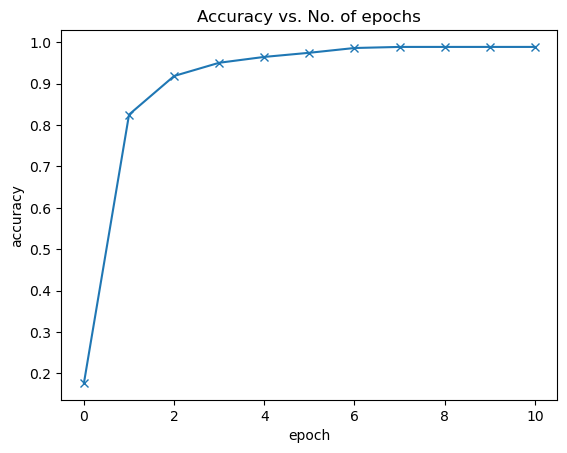

In [ ]:
plot_accuracies(xfer_lr_history)

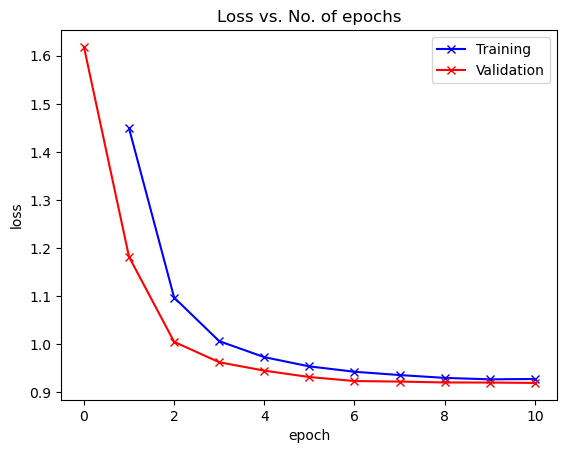

In [ ]:
plot_losses(xfer_lr_history)

### D. Make predictions on samples

Winner is Transfer learning using GoogleNet, because best accuracy in minimum time. So Let's use to predict the sample images and save the model

In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return original_dataset.classes[preds[0].item()]

Predict random 5 images from validation dataset

In [ ]:
def denormalize(img, means, stds):
    img = img.permute(1,2,0)
    mean = torch.FloatTensor(means)
    std = torch.FloatTensor(stds)
    
    img = img*std + mean
        
    return np.clip(img,0,1)

In [ ]:
def model_test(dataset, images_to_print=5):
    fig, ax = plt.subplots(figsize=(8,12), nrows=images_to_print)
    for row in range(images_to_print):
        img_idx = np.random.randint(0, len(dataset))
        img, label = dataset[img_idx]
        ax[row].imshow(denormalize(img,stats[0], stats[1]))
        label = original_dataset.classes[label]
        ax[row].set_title(f'Real : {label}')
        ax[row].axis('off')
        predicted = predict_image(img, xfer_learning_model)
        print(f'Label: {label}, Predicted: {predicted}')
        plt.tight_layout()

Testing on validation dataset

Label: tulip, Predicted: tulip
Label: tulip, Predicted: tulip
Label: rose, Predicted: rose
Label: dandelion, Predicted: dandelion
Label: rose, Predicted: rose


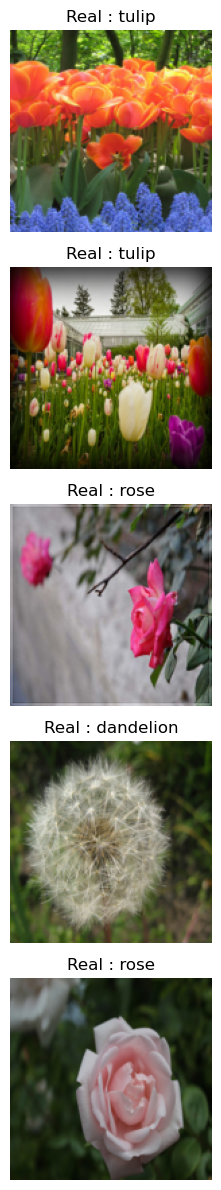

In [ ]:
model_test(val_ds)

### E. Evaluate on the test dataset

Label: daisy, Predicted: daisy
Label: daisy, Predicted: daisy
Label: rose, Predicted: rose
Label: dandelion, Predicted: dandelion
Label: dandelion, Predicted: dandelion


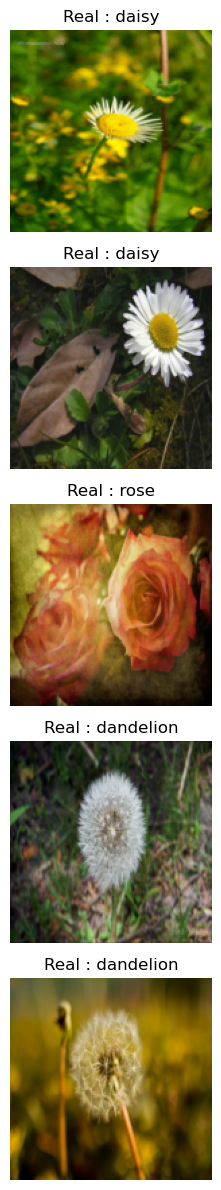

In [ ]:
model_test(test_ds)

### F. Save the model weights

In [ ]:
model_save_file_name = 'Flowers-xfer_learning_GoogleNet.pth'

In [ ]:
torch.save(xfer_learning_model.state_dict(), model_save_file_name)

### H. Try different hyperparameters & regularization

In [ ]:
epochs = 8
max_lr = 0.1
grad_clip = 0.01
weight_decay = 1e-2
opt_func = torch.optim.Adam

In [ ]:
xfer_learning_model = to_device(XferLearningGooglenet(3, num_classes), device)

In [ ]:
xfer_lr_history = [evaluate(xfer_learning_model, val_dl)]
xfer_lr_history

[{'val_loss': 1.5997638702392578, 'val_acc': 0.2666666805744171}]

In [ ]:
xfer_learning_model.freeze()

In [ ]:
xfer_lr_history += fit_one_cycle(epochs, max_lr, xfer_learning_model, train_dl, val_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay,
                             opt_func=opt_func)

Epoch [0], last_lr: 0.03944, train_loss: 1.3937, val_loss: 1.6372, val_acc: 0.2589
Epoch [1], last_lr: 0.09355, train_loss: 1.5384, val_loss: 1.5969, val_acc: 0.2589
Epoch [2], last_lr: 0.09719, train_loss: 1.6036, val_loss: 1.6009, val_acc: 0.2188
Epoch [3], last_lr: 0.08117, train_loss: 1.6032, val_loss: 1.6014, val_acc: 0.2589
Epoch [4], last_lr: 0.05560, train_loss: 1.6030, val_loss: 1.6007, val_acc: 0.2589
Epoch [5], last_lr: 0.02831, train_loss: 1.6025, val_loss: 1.5994, val_acc: 0.2589
Epoch [6], last_lr: 0.00766, train_loss: 1.6021, val_loss: 1.6016, val_acc: 0.2589
Epoch [7], last_lr: 0.00000, train_loss: 1.6026, val_loss: 1.6011, val_acc: 0.2589


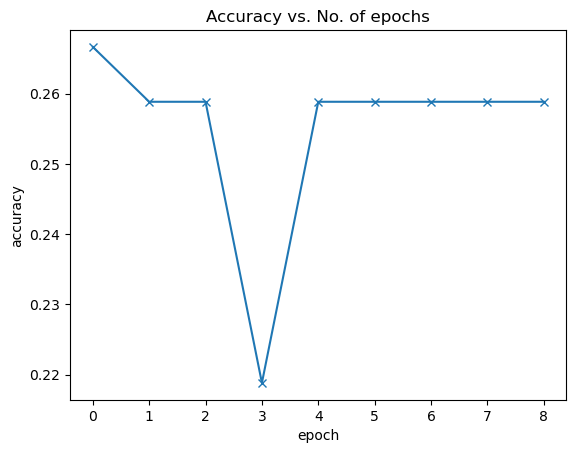

In [ ]:
plot_accuracies(xfer_lr_history)

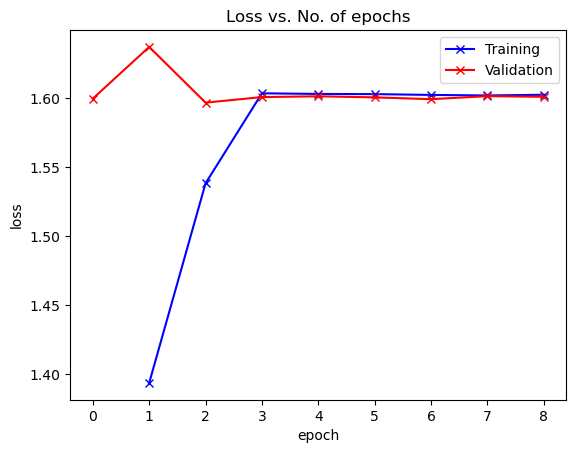

In [ ]:
plot_losses(xfer_lr_history)

## Conclusions

* All The models are giving really good accuracy
* As expected, transfer learning can give highest accuracy and it also need less time to train (if we use pretrain weights)

### Future Work

* Now i can use donwload/scrape random images of flower and try to predict the real world data with the model to actually test its performance in real life

## Reference

1. https://www.kaggle.com/code/georgiisirotenko/pytorch-flowers-translearing-ensemble-test-99-67/notebook
2. https://towardsdatascience.com/how-to-calculate-the-mean-and-standard-deviation-normalizing-datasets-in-pytorch-704bd7d05f4c
3. https://jovian.ai/learn/deep-learning-with-pytorch-zero-to-gans/lesson/lesson-5-data-augmentation-regularization-and-resnets#C25
4. https://jovian.ai/learn/deep-learning-with-pytorch-zero-to-gans/lesson/lesson-4-image-classification-with-cnn
5. https://www.youtube.com/watch?v=y6IEcEBRZks
6. https://www.youtube.com/watch?v=wnK3uWv_WkU&t=302s